## Kaggle 泰坦尼克号幸存者预测

### 1.数据预处理

#### 数据预览

In [19]:
import pandas as pd
import numpy as np

# 数据加载
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
# 数据规模
print("train shape:", train.shape)
print("test shape:", test.shape)
# 数据预览
display(train.head(10))
display(train.isna().sum())
display(test.isna().sum())

train shape: (891, 12)
test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#### 数据清洗

In [20]:
def data_process(data):
    # 缺失的登船地点直接用众数填充
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    # 统计年龄与其他数字项的相关程度
    # tmp = data[['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
    # display(tmp.corr()['Age'].sort_values())
    # 计算各个 Pclass 的年龄中位数
    display(data.groupby('Pclass')['Age'].median())
    # 用各个 Pclass 的年龄中位数填充
    data['Age'].fillna(data.groupby('Pclass')['Age'].transform('median'), inplace=True)
    # # 船舱号缺失值过多，只考虑有无船舱号
    data['Cabin'].fillna(0, inplace=True)
    data.loc[data['Cabin'] != 0, 'Cabin'] = 1
    # 直接删除
    # train.drop(['Cabin'], axis=1, inplace=True)
    # 姓名，只保留称谓
    data['Name'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Ticket 是独一无二的，直接删除
    #data.drop(['Ticket'], axis=1, inplace=True)

    #用 -1 填充 Ticket
    data['Ticket'].fillna(-1, inplace=True)
    return data

train = data_process(train)
display(train.isna().sum())
display(train.head(10))

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,1,C
2,3,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,Mrs,female,35.0,1,0,113803,53.1000,1,S
4,5,0,3,Mr,male,35.0,0,0,373450,8.0500,0,S
5,6,0,3,Mr,male,24.0,0,0,330877,8.4583,0,Q
6,7,0,1,Mr,male,54.0,0,0,17463,51.8625,1,S
7,8,0,3,Master,male,2.0,3,1,349909,21.0750,0,S
8,9,1,3,Mrs,female,27.0,0,2,347742,11.1333,0,S
9,10,1,2,Mrs,female,14.0,1,0,237736,30.0708,0,C


#### 特征统计

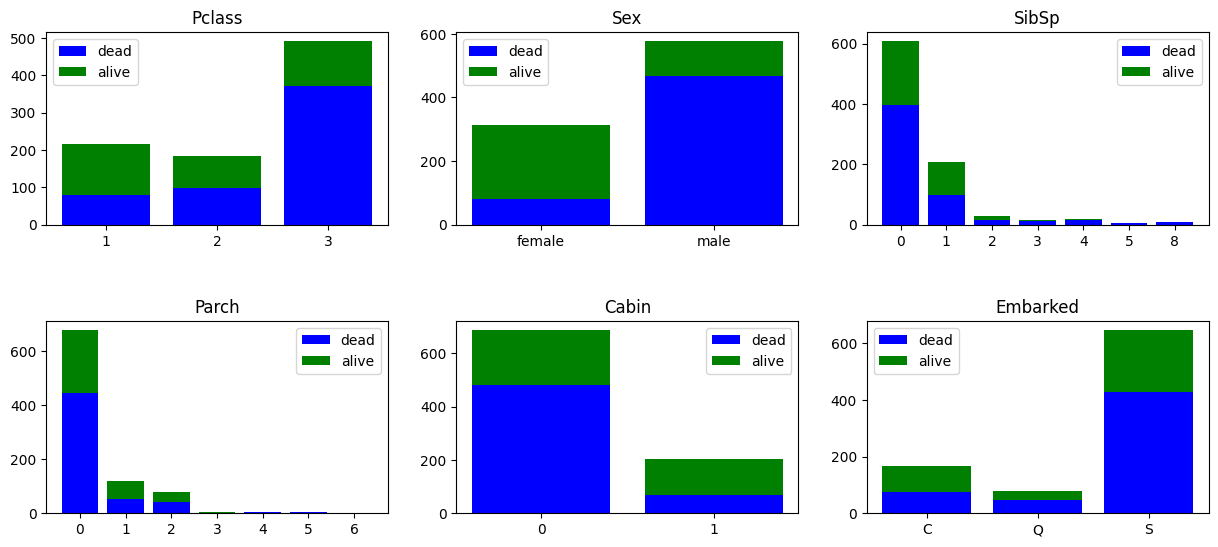

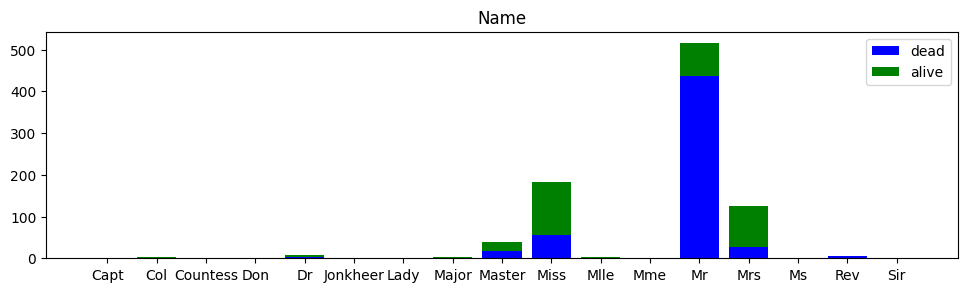

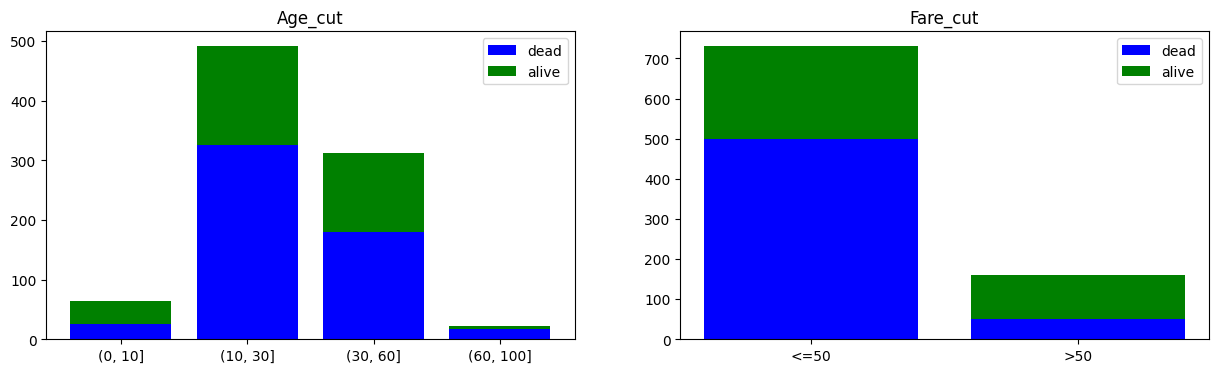

In [21]:
import matplotlib.pyplot as plt
# 画出特征与对应存活人数的堆叠柱状图
def plot_bar(feature, type=0):
    # 离散型特征
    if type == 0:
        # 横坐标为特征取值，可能是非数值型
        value = train[feature].unique()
        # 横坐标排序
        value.sort()
        y1 = []
        y2 = []
        for x_i in value:
            y1.append(train.loc[(train[feature] == x_i) & (train['Survived'] == 0)].shape[0])
            y2.append(train.loc[(train[feature] == x_i) & (train['Survived'] == 1)].shape[0])
        # 画图
        x = range(len(value))
        plt.bar(x, y1, color='b', label='dead')
        plt.bar(x, y2, bottom=y1, color='g', label='alive')
        # 设置横坐标刻度
        plt.xticks(x, value)
        plt.legend()
        plt.title(feature)

plt.figure(figsize=(15, 10))
# 增加上下间距
plt.subplots_adjust(hspace=0.5)
plt.subplot(3, 3, 1)
plot_bar('Pclass')
plt.subplot(3, 3, 2)
plot_bar('Sex')
plt.subplot(3, 3, 3)
plot_bar('SibSp')
plt.subplot(3, 3, 4)
plot_bar('Parch')
plt.subplot(3, 3, 5)
plot_bar('Cabin')
plt.subplot(3, 3, 6)
plot_bar('Embarked')
plt.figure(figsize=(40, 10))
plt.subplot(3, 3, 7)
plot_bar('Name')
plt.show()

# 年龄划分为四个区间：0~10为儿童；10~30为年轻人；30~60为中年人；60以上为老年人
# 新建一列 Age_cut，字符串类型
train['Age_cut'] = '(0, 10]'
# 将年龄划分为四个区间
train.loc[train['Age'] > 10, 'Age_cut'] = '(10, 30]'
train.loc[train['Age'] > 30, 'Age_cut'] = '(30, 60]'
train.loc[train['Age'] > 60, 'Age_cut'] = '(60, 100]'
# 画出年龄分布
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
plt.subplot(2, 2, 1)
plot_bar('Age_cut')
# 票价每 50 为一个区间
train['Fare_cut'] = '<=50'
train.loc[train['Fare'] > 50, 'Fare_cut'] = '>50'
plt.subplot(2, 2, 2)
plot_bar('Fare_cut')
plt.show()
train.drop(['Age_cut', 'Fare_cut'], axis=1, inplace=True)

### 2.模型构建

#### 特征工程

In [22]:
import sklearn.preprocessing as preprocessing
# 特征因子化, one-hot 编码
def set_numeralization(data):
    # 针对定类性属性进行因子化，分别有Embarked,Sex,Pclass
    dummies_Embarked = pd.get_dummies(data['Embarked'], prefix='Embarked')
    dummies_Sex = pd.get_dummies(data['Sex'], prefix='Sex')
    dummies_Pclass = pd.get_dummies(data['Pclass'], prefix='Pclass')
    # 将 Name 转为数值型，保留人数大于 10 的称谓
    name = data['Name'].value_counts()
    name = name[name > 10].index
    data.loc[~data['Name'].isin(name), 'Name'] = 0
    dummies_Name = pd.get_dummies(data['Name'], prefix='Name')

    # 将新的属性拼合
    df = pd.concat([data, dummies_Name, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
    # 将旧的属性剔除
    df.drop(['Name', 'Pclass', 'Sex', 'Embarked'], axis=1, inplace=True)
    return df

# 特征归一化
def set_normalization(df):
    scaler = preprocessing.StandardScaler()
    age_scale_param = scaler.fit(df['Age'].values.reshape(-1,1))
    df['Age_scaled'] = scaler.fit_transform(df['Age'].values.reshape(-1,1),age_scale_param)
    fare_scale_param = scaler.fit(df['Fare'].values.reshape(-1,1))
    df['Fare_scaled'] = scaler.fit_transform(df['Fare'].values.reshape(-1,1),fare_scale_param)
    df.drop(['Age', 'Fare'], axis=1, inplace=True)
    return df

def set_planarization(data):
    #离散化 Age Fare
    #使用pd中的cut离散化
    #data['Age'] = pd.cut(data['Age'], bins=4, labels=[1, 2, 3, 4])
    #data['Fare'] = pd.cut(data['Fare'], bins=2, labels=[1, 2])
    #手动离散化
    for i in range(0,data['Age'].size):
        if (0 < data.loc[i,'Age'] and data.loc[i,'Age'] <= 10):
            data.loc[i,'Age'] = 1
        if (10 < data.loc[i,'Age'] and data.loc[i,'Age'] <= 30):
            data.loc[i,'Age'] = 2
        if (30 < data.loc[i,'Age'] and data.loc[i,'Age'] <= 60):
            data.loc[i,'Age'] = 3
        if (60 < data.loc[i,'Age'] and data.loc[i,'Age'] <= 100):
            data.loc[i,'Age'] = 4
    for i in range(0,data['Fare'].size):
        if (data.loc[i,'Fare'] <= 50):
            data.loc[i,'Fare'] = 1
        if (data.loc[i,'Fare'] > 50):
            data.loc[i,'Fare'] = 2
    #处理ticket 同一张ticket被多个人使用，则他们在船上有同伴，赋值为1，否则赋值为0
    #使用pd里的duplicated查重复值
    #data['Companion'] = data.duplicated(subset='Ticket', keep=False).astype(int)
    #手动
    for i in range(0,data['Ticket'].size):
        flag = 0
        #-1表示缺失
        if data.loc[i,'Ticket'] == -1:
            data.loc[i,'Ticket'] = 0
            continue
        if data.loc[i,'Ticket'] != 1:
            for j in range(i + 1,data['Ticket'].size):
                if (data.loc[i,'Ticket'] == data.loc[j,'Ticket']):
                    flag = 1
                    data.loc[j,'Ticket'] = flag
        data.loc[i,'Ticket'] = flag
    return data

# 特征工程
train = set_planarization(train)
train = set_numeralization(train)
train = set_normalization(train)
display(train.head(10))
# 划分训练集和验证集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train.drop(['PassengerId', 'Survived'], axis=1), train['Survived'], test_size=0.3, random_state=42)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# 测试集
# 读取测试集
test = pd.read_csv("../data/test.csv")
# 数据预处理
test = data_process(test)
# 有个坑，测试集中 Fare 有一个缺失值，用对应 Pclass 的中位数填充
test['Fare'].fillna(test.groupby('Pclass')['Fare'].transform('median'), inplace=True)
# 特征工程
test = set_planarization(test)
test = set_numeralization(test)
test = set_normalization(test)
display(test.head(10))
x_exam = test.drop(['PassengerId'], axis=1)

,PassengerId,Survived,SibSp,Parch,Ticket,Cabin,Name_0,Name_Master,Name_Miss,Name_Mr,...,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age_scaled,Fare_scaled
0,1,0,1,0,0,0,False,False,False,True,...,False,False,True,False,True,False,False,True,-0.511237,-0.467844
1,2,1,1,0,0,1,False,False,False,False,...,True,False,False,True,False,True,False,False,1.043412,2.137463
2,3,1,0,0,0,0,False,False,True,False,...,False,False,True,True,False,False,False,True,-0.511237,-0.467844
3,4,1,1,0,1,1,False,False,False,False,...,False,False,True,True,False,True,False,False,1.043412,2.137463
4,5,0,0,0,0,0,False,False,False,True,...,False,False,True,False,True,False,False,True,1.043412,-0.467844
5,6,0,0,0,0,0,False,False,False,True,...,False,True,False,False,True,False,False,True,-0.511237,-0.467844
6,7,0,0,0,0,1,False,False,False,True,...,False,False,True,False,True,True,False,False,1.043412,2.137463
7,8,0,3,1,1,0,False,True,False,False,...,False,False,True,False,True,False,False,True,-2.065887,-0.467844
8,9,1,0,2,1,0,False,False,False,False,...,False,False,True,True,False,False,False,True,-0.511237,-0.467844
9,10,1,1,0,1,0,False,False,False,False,...,True,False,False,True,False,False,True,False,-0.511237,-0.467844


x_train shape: (623, 19)
x_test shape: (268, 19)
y_train shape: (623,)
y_test shape: (268,)


Pclass
1    42.0
2    26.5
3    24.0
Name: Age, dtype: float64

,PassengerId,SibSp,Parch,Ticket,Cabin,Name_0,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age_scaled,Fare_scaled
0,892,0,0,0,0,False,False,False,True,False,False,True,False,False,True,False,False,True,1.129386,-0.486504
1,893,1,0,0,0,False,False,False,False,True,False,False,True,True,False,False,False,True,1.129386,-0.486504
2,894,0,0,0,0,False,False,False,True,False,False,True,False,False,True,False,True,False,2.768564,-0.486504
3,895,0,0,0,0,False,False,False,True,False,False,False,True,False,True,False,False,True,-0.509792,-0.486504
4,896,1,1,0,0,False,False,False,False,True,False,False,True,True,False,False,False,True,-0.509792,-0.486504
5,897,0,0,0,0,False,False,False,True,False,False,False,True,False,True,False,False,True,-0.509792,-0.486504
6,898,0,0,0,0,False,False,True,False,False,False,True,False,True,False,False,False,True,-0.509792,-0.486504
7,899,1,1,0,0,False,False,False,True,False,False,False,True,False,True,False,True,False,-0.509792,-0.486504
8,900,0,0,0,0,False,False,False,False,True,True,False,False,True,False,False,False,True,-0.509792,-0.486504
9,901,2,0,0,0,False,False,False,True,False,False,False,True,False,True,False,False,True,-0.509792,-0.486504


#### 训练模型

##### 逻辑回归

In [23]:
# 逻辑回归模型，训练集为 train，标签为 Survived
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
# 训练
lr.fit(x_train, y_train)
# 预测
# display(x_train.head(10))
# 输出准确率
print("Accuracy:", lr.score(x_test, y_test))
# 预测
y_exam = lr.predict(x_exam)
# 保存结果
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_exam})
result.to_csv("../result/lr_predict.csv", index=False)

Accuracy: 0.8171641791044776


##### SVM 支持向量机

In [24]:
# SVM 模型
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(x_train, y_train)
print("Accuracy:", svc.score(x_test, y_test))
y_exam = svc.predict(x_exam)
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_exam})
result.to_csv("../result/svm_predict.csv", index=False)

Accuracy: 0.8246268656716418


##### K最近邻算法

In [25]:
# K 最近邻模型
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
print("Accuracy:", knn.score(x_test, y_test))
y_exam = knn.predict(x_exam)
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_exam})
result.to_csv("../result/knn_predict.csv", index=False)

Accuracy: 0.7947761194029851


##### 决策树

In [26]:
# 决策树模型
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
print("Accuracy:", dt.score(x_test, y_test))
y_exam = dt.predict(x_exam)
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_test})
result.to_csv("../result/dt_predict.csv", index=False)

# 调参 max_depth, min_samples_split, min_samples_leaf
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': np.arange(1, 10), 'min_samples_split': np.arange(2, 10), 'min_samples_leaf': np.arange(1, 10)}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)
print(grid.best_params_)
dt_best = grid.best_estimator_
dt_best.fit(x_train, y_train)
print("Accuracy:", dt_best.score(x_test, y_test))
y_exam = dt_best.predict(x_exam)
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_exam})
result.to_csv("../result/dt_best_predict.csv", index=False)

Accuracy: 0.7835820895522388
{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy: 0.7835820895522388


##### 随机森林

In [27]:
# 随机森林模型
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print("Accuracy:", rf.score(x_test, y_test))
y_exam = rf.predict(x_exam)
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_test})
result.to_csv("../result/rf_predict.csv", index=False)

# 调参 n_estimators, max_depth, min_samples_split, min_samples_leaf
# 使用 RandomizedSearchCV, 速度更快
from sklearn.model_selection import RandomizedSearchCV
param_grid = {'n_estimators': np.arange(10, 100), 'max_depth': np.arange(1, 10), 'min_samples_split': np.arange(2, 10), 'min_samples_leaf': np.arange(1, 10)}
grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)
print(grid.best_params_)
rf_best = grid.best_estimator_
rf_best.fit(x_train, y_train)
print("Accuracy:", rf_best.score(x_test, y_test))
y_exam = rf_best.predict(x_exam)
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_exam})
result.to_csv("../result/rf_best_predict.csv", index=False)
# 记一下最好的参数
# {'n_estimators': 46, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 7}


Accuracy: 0.7910447761194029
{'n_estimators': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}
Accuracy: 0.8283582089552238


#### 模型融合

In [28]:
# 选择效果比较好的模型，进行集成学习
# 使用 VotingClassifier
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('lr', lr), ('svc', svc), ('knn', knn), ('dt', dt_best), ('rf', rf_best)], voting='soft')
voting.fit(x_train, y_train)
print("Accuracy:", voting.score(x_test, y_test))
y_exam = voting.predict(x_exam)
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_exam})
result.to_csv("../result/voting_predict.csv", index=False)

Accuracy: 0.8097014925373134


### 3.模型评估

#### 交叉验证

In [29]:
# 交叉验证评估模型
from sklearn.model_selection import cross_val_score
# 逻辑回归
lr_cv = cross_val_score(lr, x_train, y_train, cv=5)
print("lr_cv:", lr_cv.mean())
# SVM
svc_cv = cross_val_score(svc, x_train, y_train, cv=5)
print("svc_cv:", svc_cv.mean())
# KNN
knn_cv = cross_val_score(knn, x_train, y_train, cv=5)
print("knn_cv:", knn_cv.mean())
# 决策树
dt_cv = cross_val_score(dt_best, x_train, y_train, cv=5)
print("dt_cv:", dt_cv.mean())
# 随机森林
rf_cv = cross_val_score(rf_best, x_train, y_train, cv=5)
print("rf_cv:", rf_cv.mean())
# 融合模型
voting_cv = cross_val_score(voting, x_train, y_train, cv=5)
print("voting_cv:", voting_cv.mean())

lr_cv: 0.8394451612903225
svc_cv: 0.8298451612903227
knn_cv: 0.8105806451612902
dt_cv: 0.8330967741935484
rf_cv: 0.8282322580645161
voting_cv: 0.8282322580645163


#### 混淆矩阵

In [30]:
# 输出准确率、召回率、F1 值的表格
from sklearn.metrics import confusion_matrix
# 逻辑回归
lr_cm = confusion_matrix(y_train, lr.predict(x_train))
lr_precision = lr_cm[1, 1] / (lr_cm[0, 1] + lr_cm[1, 1])
lr_recall = lr_cm[1, 1] / (lr_cm[1, 0] + lr_cm[1, 1])
lr_f1 = 2 * lr_precision * lr_recall / (lr_precision + lr_recall)
# SVM
svc_cm = confusion_matrix(y_train, svc.predict(x_train))
svc_precision = svc_cm[1, 1] / (svc_cm[0, 1] + svc_cm[1, 1])
svc_recall = svc_cm[1, 1] / (svc_cm[1, 0] + svc_cm[1, 1])
svc_f1 = 2 * svc_precision * svc_recall / (svc_precision + svc_recall)
# KNN
knn_cm = confusion_matrix(y_train, knn.predict(x_train))
knn_precision = knn_cm[1, 1] / (knn_cm[0, 1] + knn_cm[1, 1])
knn_recall = knn_cm[1, 1] / (knn_cm[1, 0] + knn_cm[1, 1])
knn_f1 = 2 * knn_precision * knn_recall / (knn_precision + knn_recall)
# 决策树
dt_cm = confusion_matrix(y_train, dt_best.predict(x_train))
dt_precision = dt_cm[1, 1] / (dt_cm[0, 1] + dt_cm[1, 1])
dt_recall = dt_cm[1, 1] / (dt_cm[1, 0] + dt_cm[1, 1])
dt_f1 = 2 * dt_precision * dt_recall / (dt_precision + dt_recall)
# 随机森林
rf_cm = confusion_matrix(y_train, rf_best.predict(x_train))
rf_precision = rf_cm[1, 1] / (rf_cm[0, 1] + rf_cm[1, 1])
rf_recall = rf_cm[1, 1] / (rf_cm[1, 0] + rf_cm[1, 1])
rf_f1 = 2 * rf_precision * rf_recall / (rf_precision + rf_recall)
# 融合模型
voting_cm = confusion_matrix(y_train, voting.predict(x_train))
voting_precision = voting_cm[1, 1] / (voting_cm[0, 1] + voting_cm[1, 1])
voting_recall = voting_cm[1, 1] / (voting_cm[1, 0] + voting_cm[1, 1])
voting_f1 = 2 * voting_precision * voting_recall / (voting_precision + voting_recall)
# 表格形式输出
df = pd.DataFrame({'precision': [lr_precision, svc_precision, knn_precision, dt_precision, rf_precision, voting_precision],
                   'recall': [lr_recall, svc_recall, knn_recall, dt_recall, rf_recall, voting_recall],
                   'f1': [lr_f1, svc_f1, knn_f1, dt_f1, rf_f1, voting_f1]},
                  index=['lr', 'svc', 'knn', 'dt', 'rf', 'voting'])
display(df)

,precision,recall,f1
lr,0.820755,0.753247,0.785553
svc,0.867725,0.709957,0.780952
knn,0.871795,0.735931,0.798122
dt,0.870466,0.727273,0.792453
rf,0.903409,0.688312,0.781327
voting,0.864322,0.744589,0.800000


#### ROC曲线

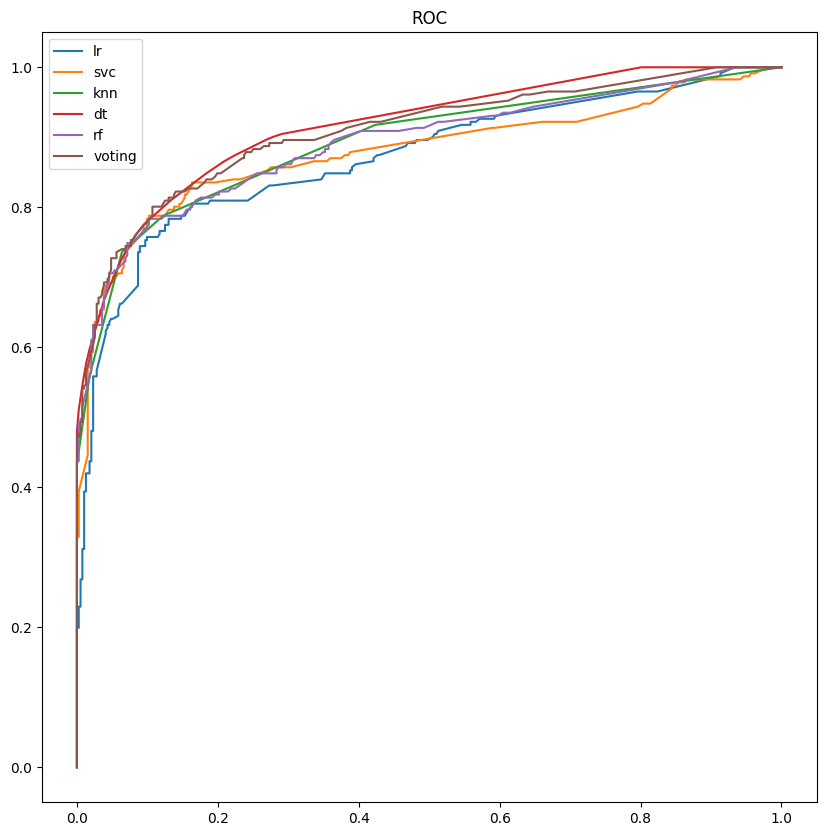

In [31]:
from sklearn.metrics import roc_curve
# 逻辑回归
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_train, lr.predict_proba(x_train)[:, 1])
# SVM
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_train, svc.decision_function(x_train))
# KNN
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_train, knn.predict_proba(x_train)[:, 1])
# 决策树
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_train, dt_best.predict_proba(x_train)[:, 1])
# 随机森林
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_train, rf_best.predict_proba(x_train)[:, 1])
# 融合模型，硬投票
voting_fpr, voting_tpr, voting_thresholds = roc_curve(y_train, voting.predict_proba(x_train)[:, 1])

# 画出 ROC 曲线
plt.figure(figsize=(10, 10))
plt.title('ROC')
plt.plot(lr_fpr, lr_tpr, label='lr')
plt.plot(svc_fpr, svc_tpr, label='svc')
plt.plot(knn_fpr, knn_tpr, label='knn')
plt.plot(dt_fpr, dt_tpr, label='dt')
plt.plot(rf_fpr, rf_tpr, label='rf')
plt.plot(voting_fpr, voting_tpr, label='voting')
plt.legend()
plt.show()